In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import json, joblib

df = pd.read_csv("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Data\\processed\\nfhs4_final_segmented.csv")

with open("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Data\\processed\\selected_features.json") as f:
    Selected_features = json.load(f)

TARGET = "stunting"

# Define risk segment order and colors for consistent visualization
Segment_order  = [
    "Tier 3 — High Risk",
    "Tier 2 — Moderate Risk",
    "Tier 1 — Low Risk (Developed)"]
# Colors for risk segments

Segment_colour = {
    "Tier 3 — High Risk"          : "#E74C3C",
    "Tier 2 — Moderate Risk"      : "#F1C40F",
    "Tier 1 — Low Risk (Developed)": "#2ECC71"}

print(f" Loaded: {df.shape}")
print(df["risk_segment"].value_counts().to_string())

 Loaded: (607, 40)
risk_segment
Tier 1 — Low Risk (Developed)    296
Tier 3 — High Risk               243
Tier 2 — Moderate Risk            68


In [9]:
# Identify top 30 priority districts based on stunting rates and key risk factors
priority_cols = [
    "state", "district", "stunting", "risk_segment",
    "empowerment_score", "wash_score", "wealth_proxy",
    "nutrition_deprivation", "fertility_risk", "healthcare_score",
    "predicted_stunting_rf", "residual_rf"]

priority = (df[priority_cols].sort_values("stunting", ascending=False).head(30).reset_index(drop=True))
priority.index += 1   # rank from 1

print("  TOP 30 PRIORITY DISTRICTS FOR POLICY INTERVENTION")
print(priority[["state", "district", "stunting","empowerment_score", "wash_score","nutrition_deprivation", "fertility_risk"]].to_string())

priority.to_csv("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Outputs\\reports\\priority_districts.csv", index_label="Rank")

  TOP 30 PRIORITY DISTRICTS FOR POLICY INTERVENTION
   state             district  stunting  empowerment_score  wash_score  nutrition_deprivation  fertility_risk
1     UP             Bahraich      65.1          31.933333   42.300000                 36.975       30.966667
2     UP            Shrawasti      63.5          28.233333   39.200000                 32.825       39.566667
3     UP            Balrampur      62.8          31.966667   40.500000                 34.025       30.233333
4     JH  Pashchimi Singhbhum      59.4          40.433333   31.666667                 40.275       21.400000
5     UP       Siddharthnagar      57.9          40.566667   44.600000                 42.525       29.933333
6     BR            Sitamarhi      57.3          34.400000   44.333333                 40.925       34.133333
7     UP                Gonda      56.9          40.533333   43.400000                 35.825       30.800000
8     UP              Sitapur      56.4          44.000000   44.8000

  SEGMENT PROFILE — MEAN FEATURE VALUES BY RISK TIER
risk_segment                Tier 3 — High Risk  Tier 2 — Moderate Risk  Tier 1 — Low Risk (Developed)
Women's Empowerment                       47.2                    57.4                           63.6
Household Wealth                          52.0                    60.0                           68.0
WASH Access                               47.1                    53.8                           65.4
Healthcare Access                         46.7                    43.1                           71.8
Nutrition Deprivation                     34.0                    20.2                           27.2
Fertility Risk                            24.5                    22.8                           16.6
Immunization Coverage                     72.6                    61.6                           84.2
Iron Folic Acid (100 days)                16.1                    20.5                           44.1
OOP Delivery Cost (Rs.)      

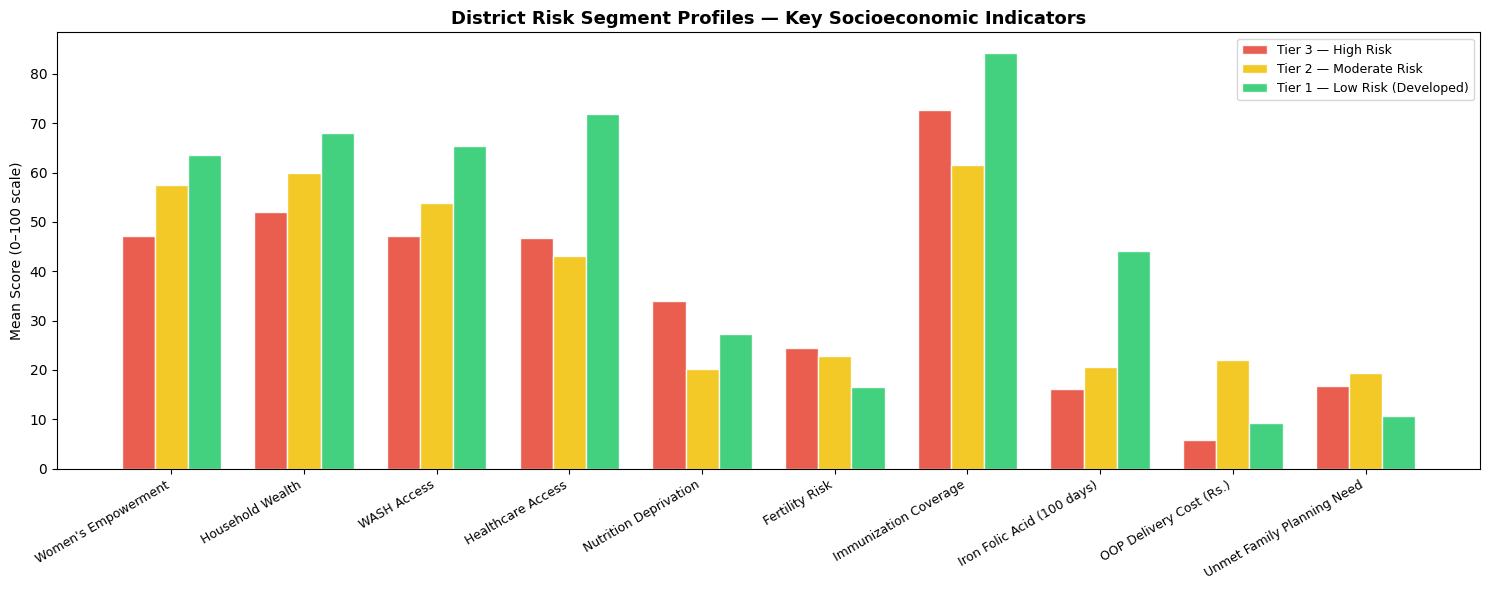

In [10]:
# Create segment profiles by calculating mean values of key features for each risk tier
Profile_features = {
    "empowerment_score"   : "Women's Empowerment",
    "wealth_proxy"        : "Household Wealth",
    "wash_score"          : "WASH Access",
    "healthcare_score"    : "Healthcare Access",
    "nutrition_deprivation": "Nutrition Deprivation",
    "fertility_risk"      : "Fertility Risk",
    "immunization_score"  : "Immunization Coverage",
    "ifa_100days"         : "Iron Folic Acid (100 days)",
    "oop_delivery_cost"   : "OOP Delivery Cost (Rs.)",
    "unmet_need_total"    : "Unmet Family Planning Need"}

seg_profile = (df.groupby("risk_segment")[list(Profile_features.keys())].mean().round(1).loc[Segment_order].rename(columns=Profile_features).T)

print("  SEGMENT PROFILE — MEAN FEATURE VALUES BY RISK TIER")
print(seg_profile.to_string())

# Grouped bar chart 
fig, ax = plt.subplots(figsize=(15, 6))
x = np.arange(len(seg_profile))
width = 0.25
colors = [Segment_colour[s] for s in Segment_order]

for i, (seg, color) in enumerate(zip(Segment_order, colors)):
    vals = seg_profile[seg].values
    # Normalize OOP cost to 0-100 scale for comparability
    vals_norm = vals.copy().astype(float)
    oop_idx   = list(Profile_features.values()).index("OOP Delivery Cost (Rs.)")
    vals_norm[oop_idx] = vals_norm[oop_idx] / 315   # scale to ~0-100
    bars = ax.bar(x + i * width, vals_norm, width, label=seg, color=color, edgecolor="white", alpha=0.9)

ax.set_xticks(x + width)
ax.set_xticklabels(list(Profile_features.values()), rotation=30, ha="right", fontsize=9)
ax.set_ylabel("Mean Score (0–100 scale)")
ax.set_title("District Risk Segment Profiles — Key Socioeconomic Indicators", fontsize=13, fontweight="bold")
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Outputs\\figures\\17_segment_profiles.png", dpi=150, bbox_inches="tight")
plt.show()

C:\Users\Fredrik\AppData\Local\Temp\ipykernel_18932\3392318723.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="risk_segment", y=TARGET,order=Segment_order,palette=Segment_colour,inner="box",ax=axes[0])
C:\Users\Fredrik\AppData\Local\Temp\ipykernel_18932\3392318723.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([s.replace(" — ", "\n") for s in Segment_order],fontsize=9)


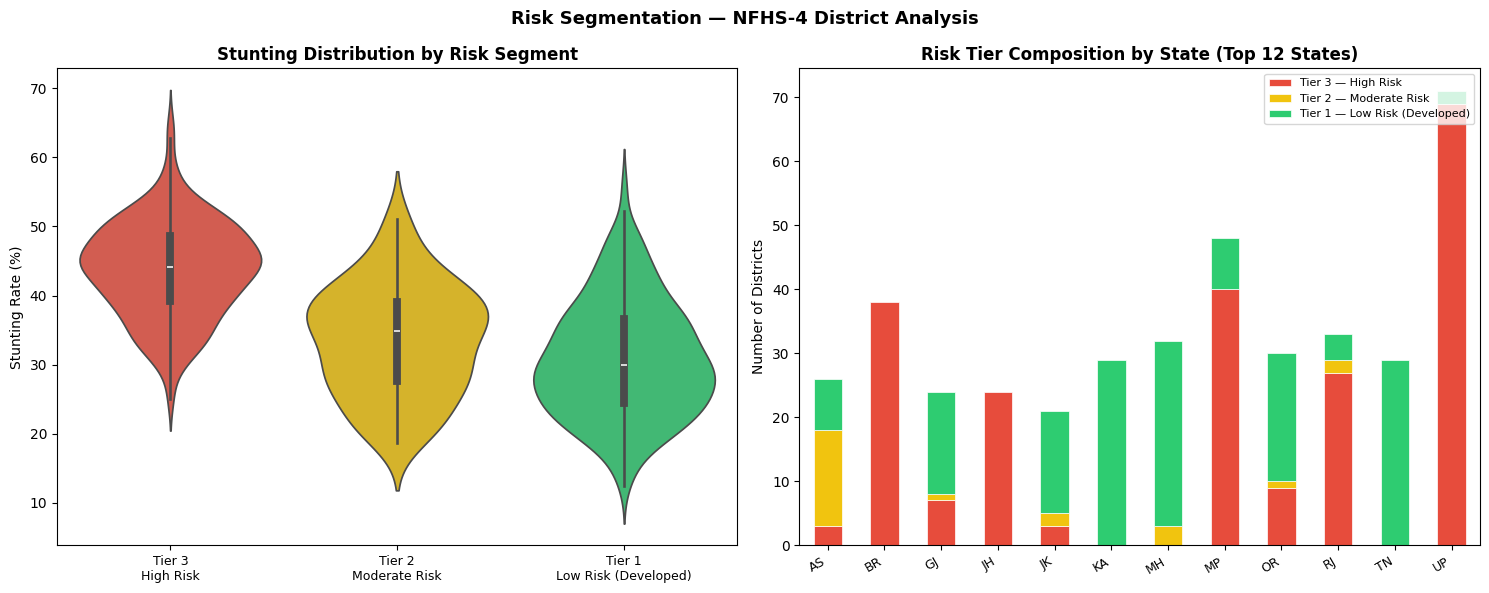

In [11]:
# Stunting distribution by risk segment and state composition within segments using violin and stacked bar charts
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Violin plot
sns.violinplot(data=df, x="risk_segment", y=TARGET,order=Segment_order,palette=Segment_colour,inner="box",ax=axes[0])
axes[0].set_title("Stunting Distribution by Risk Segment", fontweight="bold")
axes[0].set_xlabel("")
axes[0].set_ylabel("Stunting Rate (%)")
axes[0].set_xticklabels([s.replace(" — ", "\n") for s in Segment_order],fontsize=9)

# State composition per segment (stacked bar of top states)
top_states = df["state"].value_counts().head(12).index
df_top = df[df["state"].isin(top_states)]

state_seg = (df_top.groupby(["state", "risk_segment"]).size().unstack(fill_value=0)[Segment_order])

state_seg.plot(kind="bar", stacked=True, color=[Segment_colour[s] for s in Segment_order], edgecolor="white", linewidth=0.5, ax=axes[1])
axes[1].set_title("Risk Tier Composition by State (Top 12 States)", fontweight="bold")
axes[1].set_xlabel("")
axes[1].set_ylabel("Number of Districts")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30, ha="right", fontsize=9)
axes[1].legend(fontsize=8, loc="upper right")

plt.suptitle("Risk Segmentation — NFHS-4 District Analysis", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Outputs\\figures\\18_segment_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

In [12]:
# Policy recommendation summary based on segment profiles and stunting rates
recommendations = {
    "Tier 3 — High Risk" : {
    "Districts" : int((df["risk_segment"] == "Tier 3 — High Risk").sum()),
    "Avg Stunting" : f"{df[df['risk_segment']=='Tier 3 — High Risk'][TARGET].mean():.1f}%",
    "Core Problem" : "Low empowerment + high fertility risk + poor WASH",
    "Priority Actions" : [
        "Scale up girls' education and female literacy programs",
        "Enforce child marriage prevention (PCMA Act)",
        "ICDS expansion: Anganwadi coverage in every village",
        "Swachh Bharat Mission: accelerate toilet + clean water access",
        "Conditional cash transfers for ANC completion + IFA adherence"],
    "Lead Ministries" : "WCD, Health, Education, Jal Shakti"
    },

    "Tier 2 — Moderate Risk" : {
        "Districts" : int((df["risk_segment"] == "Tier 2 — Moderate Risk").sum()),
        "Avg Stunting" : f"{df[df['risk_segment']=='Tier 2 — Moderate Risk'][TARGET].mean():.1f}%",
        "Core Problem" : "Transitional districts — gains fragile, high OOP costs",
        "Priority Actions" : [
            "Reduce out-of-pocket delivery costs via JSY/JSSK strengthening",
            "Increase exclusive breastfeeding counselling at AWCs",
            "Vitamin A and IFA supplementation monitoring",
            "Improve immunization last-mile delivery (cold chain)",
            "Target unmet family planning need — ASHA worker training"],
        "Lead Ministries" : "Health, WCD, Finance",
    },

    "Tier 1 — Low Risk (Developed)" : {
        "Districts" : int((df["risk_segment"] == "Tier 1 — Low Risk (Developed)").sum()),
        "Avg Stunting" : f"{df[df['risk_segment']=='Tier 1 — Low Risk (Developed)'][TARGET].mean():.1f}%",
        "Core Problem" : "Hidden pockets of risk within otherwise developed districts",
        "Priority Actions" : [
            "Targeted surveillance in tribal/urban-poor pockets",
            "Address residual anaemia among women and children",
            "Maintain immunization coverage — prevent backsliding",
            "Diet diversity programs for 6–23 month children"],
        "Lead Ministries" : "Health, NITI Aayog"
    },
}

print("  POLICY RECOMMENDATION SUMMARY — NFHS-4 DISTRICT RISK ANALYSIS")

for tier, rec in recommendations.items():
    print(f"  {tier}")
    print(f"  Districts: {rec['Districts']}  |  Avg Stunting: {rec['Avg Stunting']}")
    print(f"  Core Problem: {rec['Core Problem']}")
    print(f"  Priority Actions:")
    for action in rec["Priority Actions"]:
        print(f"   - {action}")
    print(f"  Lead Ministries: {rec['Lead Ministries']}")

  POLICY RECOMMENDATION SUMMARY — NFHS-4 DISTRICT RISK ANALYSIS
  Tier 3 — High Risk
  Districts: 243  |  Avg Stunting: 43.8%
  Core Problem: Low empowerment + high fertility risk + poor WASH
  Priority Actions:
   - Scale up girls' education and female literacy programs
   - Enforce child marriage prevention (PCMA Act)
   - ICDS expansion: Anganwadi coverage in every village
   - Swachh Bharat Mission: accelerate toilet + clean water access
   - Conditional cash transfers for ANC completion + IFA adherence
  Lead Ministries: WCD, Health, Education, Jal Shakti
  Tier 2 — Moderate Risk
  Districts: 68  |  Avg Stunting: 33.6%
  Core Problem: Transitional districts — gains fragile, high OOP costs
  Priority Actions:
   - Reduce out-of-pocket delivery costs via JSY/JSSK strengthening
   - Increase exclusive breastfeeding counselling at AWCs
   - Vitamin A and IFA supplementation monitoring
   - Improve immunization last-mile delivery (cold chain)
   - Target unmet family planning need — AS

In [13]:
print("""
╔════════════════════════════════════════════════════════════════════════════╗
║     DISTRICT-LEVEL SOCIOECONOMIC RISK SEGMENTATION — NFHS-4                ║
║     Final Project Summary                                                  ║
╠════════════════════════════════════════════════════════════════════════════╣
║  DATA       : NFHS-4 District Factsheets | 607 districts | 29 States/UTs   ║
║  TARGET     : Child Stunting Rate (% under-5 stunted)                      ║
║  FEATURES   : 15 features across 7 policy domains                          ║
╠════════════════════════════════════════════════════════════════════════════╣
║  MODELS TRAINED                                                            ║
║    Linear Regression   R² = 0.671  RMSE = 5.99                             ║
║    Ridge Regression    R² = 0.672  RMSE = 5.98   (best linear)             ║
║    Lasso Regression    R² = 0.674  RMSE = 5.96                             ║
║    Random Forest       R² = 0.696  RMSE = 5.76   (best overall)            ║
╠════════════════════════════════════════════════════════════════════════════╣
║  TOP SHAP DRIVERS                                                          ║
║    1. Women's Empowerment Score   (SHAP = 2.40) — #1 protective factor     ║
║    2. OOP Delivery Cost           (SHAP = 1.72) — financial barrier        ║
║    3. Household Wealth Proxy      (SHAP = 1.50) — structural deprivation   ║
║    4. WASH Score                  (SHAP = 1.22) — sanitation + water       ║
║    5. Nutrition Deprivation       (SHAP = 1.05) — maternal undernutrition  ║
╠════════════════════════════════════════════════════════════════════════════╣
║  CLUSTERING  : KMeans K=3 (Silhouette = 0.261)                             ║
║    Tier 1 — Low Risk (Developed)  : 296 districts  Avg stunting = 30.8%    ║
║    Tier 2 — Moderate Risk         :  68 districts  Avg stunting = 33.6%    ║
║    Tier 3 — High Risk             : 243 districts  Avg stunting = 43.8%    ║
╠════════════════════════════════════════════════════════════════════════════╣
║  POLICY HEADLINE                                                           ║
║    243 districts (40% of India) require urgent multi-sector intervention.  ║
║    Women's education is the single strongest lever to reduce stunting.     ║
║    Financial barriers to institutional delivery remain a critical gap.     ║
╚════════════════════════════════════════════════════════════════════════════╝
""")

df.to_csv("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Outputs\\reports\\nfhs4_complete_analysis.csv", index=False)


╔════════════════════════════════════════════════════════════════════════════╗
║     DISTRICT-LEVEL SOCIOECONOMIC RISK SEGMENTATION — NFHS-4                ║
║     Final Project Summary                                                  ║
╠════════════════════════════════════════════════════════════════════════════╣
║  DATA       : NFHS-4 District Factsheets | 607 districts | 29 States/UTs   ║
║  TARGET     : Child Stunting Rate (% under-5 stunted)                      ║
║  FEATURES   : 15 features across 7 policy domains                          ║
╠════════════════════════════════════════════════════════════════════════════╣
║  MODELS TRAINED                                                            ║
║    Linear Regression   R² = 0.671  RMSE = 5.99                             ║
║    Ridge Regression    R² = 0.672  RMSE = 5.98   (best linear)             ║
║    Lasso Regression    R² = 0.674  RMSE = 5.96                             ║
║    Random Forest       R² = 0.696  RMSE = 5.76   